In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12a_autoencoder.ipynb"
_nb_title = "Autoencoder for MNIST"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Autoencoder+for+MNIST&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F12_generation%2F12a_autoencoder.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# MNIST用のオートエンコーダ  
MNISTで畳み込みオートエンコーダーをトレーニングします。  

## 実行環境
このノートブックは、TPU上でもGPU上でも実行可能です。

Vertex AI WorkbenchやColabでGPUやTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import os, shutil
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

2022-12-13 22:01:15.712224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 22:01:15.712271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 22:01:18.248013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 22:01:18.248114: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 22:01:18.248139: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-direct): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-13 22:01:18.437101: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 22:01:18.460580: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-13 22:01:18.460618: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:34189}
2022-12-13 22:01:18.479368: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-13 22:01:18.479397: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:34189}
2022-1

INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [3]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## 可視化ユーティリティ

In [4]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## オートエンコーダ  

Kerasユーティリティを使用してMNISTデータをロードします。

In [5]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

エンコーダーは入力を潜在空間へ写像します。

In [6]:
latent_dim = 2 # for easy visualization
with strategy.scope():
    encoder = tf.keras.Sequential([
        keras.Input(shape=(28, 28, 1), name="image_input"),
        layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1"),
        layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2"),
        layers.Flatten(name="e_flatten"),
        layers.Dense(latent_dim, name="e_dense")
    ], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 e_conv2 (Conv2D)            (None, 7, 7, 64)          18496     
                                                                 
 e_flatten (Flatten)         (None, 3136)              0         
                                                                 
 e_dense (Dense)             (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


デコーダーは潜在空間から画像を再構成します。

In [7]:
with strategy.scope():
    decoder = tf.keras.Sequential([
        keras.Input(shape=(latent_dim,), name="d_input"),
        layers.Dense(7 * 7 * 64, activation="relu", name="d_d1"),
        layers.Reshape((7, 7, 64), name="d_d2"),
        layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1"),
        layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")
    ], name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_d1 (Dense)                (None, 3136)              9408      
                                                                 
 d_d2 (Reshape)              (None, 7, 7, 64)          0         
                                                                 
 d_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        18464     
                                                                 
 d_conv2 (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


オートエンコーダは、エンコーダブロックとデコーダブロックで構成されます。 KerasのFunctional APIで以下のように記述します。

In [8]:
with strategy.scope():
    encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
    x = encoder(encoder_inputs)
    decoder_output = decoder(x)
    autoencoder = keras.Model(encoder_inputs, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Sequential)        (None, 2)                 25090     
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


In [9]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=BATCH_SIZE)

Epoch 1/30
69/69 [==============================] - 8s 53ms/step - loss: 0.1313
Epoch 2/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0694
Epoch 3/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0671
Epoch 4/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0617
Epoch 5/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0579
Epoch 6/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0557
Epoch 7/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0543
Epoch 8/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0532
Epoch 9/30
69/69 [==============================] - 1s 15ms/step - loss: 0.0525
Epoch 10/30
69/69 [==============================] - 1s 15ms/step - loss: 0.0519
Epoch 11/30
69/69 [==============================] - 1s 15ms/step - loss: 0.0515
Epoch 12/30
69/69 [==============================] - 1s 14ms/step - loss: 0.0511
Epoch 13/30
69/69 [==================

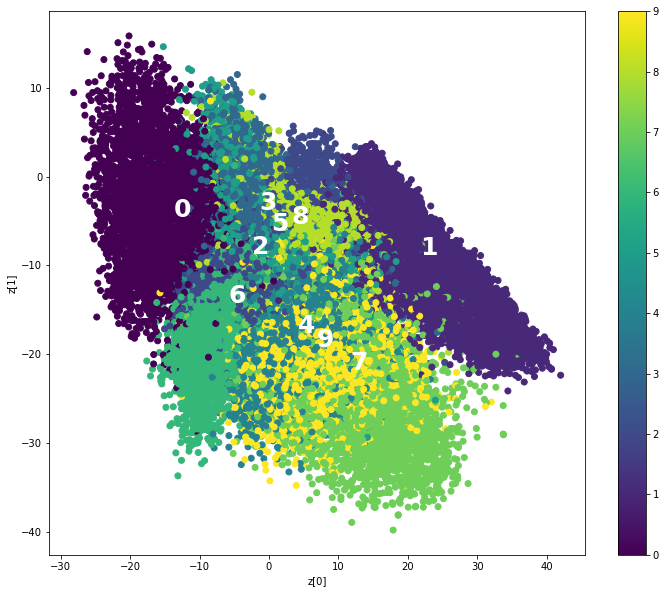

In [10]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=False)

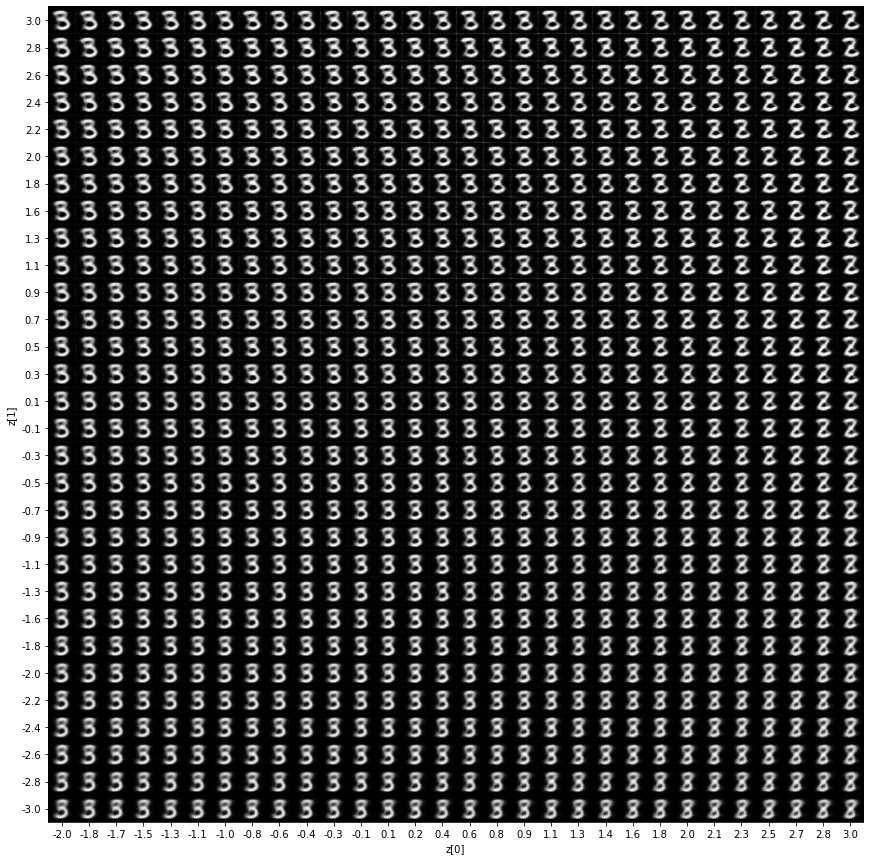

In [11]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.